In [54]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.stats import spearmanr
import statsmodels.api as sm

In [6]:
snp500_ticker = yf.Ticker("^GSPC")
snp_price = snp500_ticker.history(start='1998-10-12', end='2023-09-30', auto_adjust=True)

In [18]:
snp_price['Close']

Date
1998-10-12 00:00:00-04:00     997.710022
1998-10-13 00:00:00-04:00     994.799988
1998-10-14 00:00:00-04:00    1005.530029
1998-10-15 00:00:00-04:00    1047.489990
1998-10-16 00:00:00-04:00    1056.420044
                                ...     
2023-09-25 00:00:00-04:00    4337.439941
2023-09-26 00:00:00-04:00    4273.529785
2023-09-27 00:00:00-04:00    4274.509766
2023-09-28 00:00:00-04:00    4299.700195
2023-09-29 00:00:00-04:00    4288.049805
Name: Close, Length: 6283, dtype: float64

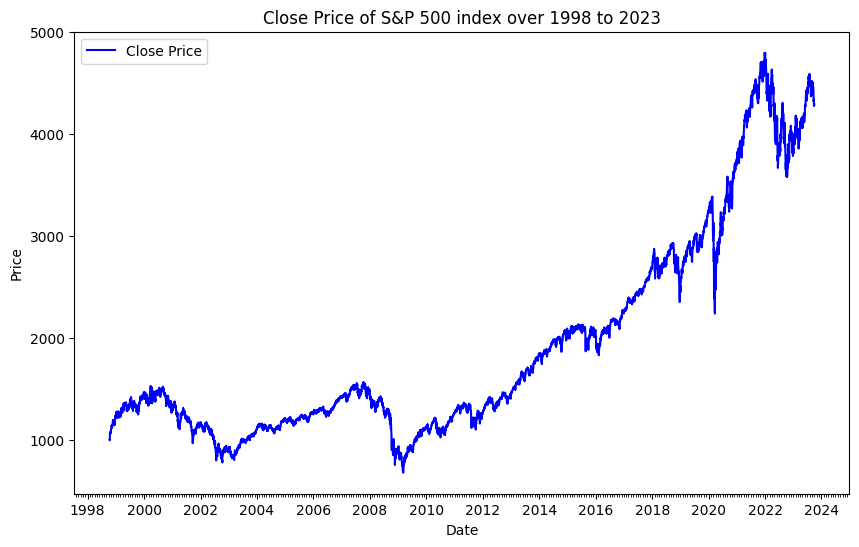

In [17]:
snp_price.index = pd.to_datetime(snp_price.index)
plt.figure(figsize=(10, 6))
plt.plot(snp_price['Close'].index, snp_price['Close'], label='Close Price', color='blue')

# Adding title and labels
plt.title('Close Price of S&P 500 index over 1998 to 2023')
plt.xlabel('Date')  # Assuming your index is date or replace it with an appropriate x-axis label
plt.ylabel('Price')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Major ticks every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks to display year
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator()) 

# plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Display the plot
plt.show()


### Problem 3 (a)

Perform the nonparametric test of independence of the log returns on
S&P500 based on the Spearman rank correlation. What is your conclusion
about whether the EMH holds? Which form of the EMH have you tested
and under which RW assumption?


In [36]:
df = pd.DataFrame()
df['Close'] = snp_price['Close']
df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))
df = df.dropna()

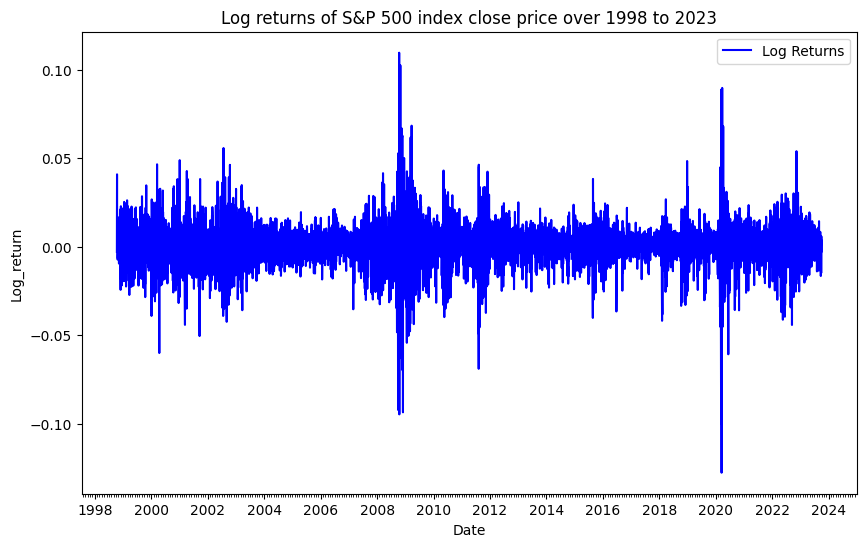

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(df['log_returns'].index, df['log_returns'], label='Log Returns', color='blue')

# Adding title and labels
plt.title('Log returns of S&P 500 index close price over 1998 to 2023')
plt.xlabel('Date')  # Assuming your index is date or replace it with an appropriate x-axis label
plt.ylabel('Log_return')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Major ticks every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks to display year
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator()) 

# plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Display the plot
plt.show()

In [38]:
df

,Close,log_returns
Date,,
1998-10-13 00:00:00-04:00,994.799988,-0.002921
1998-10-14 00:00:00-04:00,1005.530029,0.010728
1998-10-15 00:00:00-04:00,1047.489990,0.040882
1998-10-16 00:00:00-04:00,1056.420044,0.008489
1998-10-19 00:00:00-04:00,1062.390015,0.005635
...,...,...
2023-09-25 00:00:00-04:00,4337.439941,0.004015
2023-09-26 00:00:00-04:00,4273.529785,-0.014844
2023-09-27 00:00:00-04:00,4274.509766,0.000229


In [50]:
n = len(df['log_returns'])
group_1 = []
group_2 = []

for x in range(n):
    if x % 2 != 0:
        group_1.append(df.iloc[x, 1])
        
    else:
        group_2.append(df.iloc[x, 1])

group_1.sort()
group_2.sort()

differentials = [x - y for (x, y) in zip(group_1, group_2)]
R = sum(differentials)

z_stat = (6*R - n*((n**2) - 1)) / (n * (n + 1) * np.sqrt(n - 1))
z_stat

corr, p_value = spearmanr(group_1, group_2)

print(f'Hand made z-stat: {z_stat}; scipy func p-val: {p_value}')
    

Hand made z-stat: -79.25276020561701; scipy func p-val: 0.0


As we can see we have strong evidence to reject the null about the absence of dependence in log returns. However this test leverages RW1 e_i ~ iid which is very restrictive and unrealistic assumption that is not holds in returns time series as returns exhibits heteroscedasticity.

Here we attempting to test weak form of EMH as we assess the dependence only with past prices themselves. If the conditions for test would hold then we would conclude that EMH does not hold, but as we use unrealistic assumption our results inconclusive.

### Problem 3 (b)

Estimate the regression of S&P 500 log returns on a constant, the previous
day return, the returns three and nine days ago

In [53]:
df['Lag_1'] = df['log_returns'].shift(1)  
df['Lag_3'] = df['log_returns'].shift(3)  
df['Lag_9'] = df['log_returns'].shift(9)  
df = df.dropna()

(i) Are the coefficients significant (rely on standard asymptotic approximation to answer this question)? What is your conclusion
about whether the EMH holds? Which form of the EMH have you
tested this way and under which RW assumption?

In [64]:
X = sm.add_constant(df[['Lag_1', 'Lag_3', 'Lag_9']])
y = df['log_returns']

model = sm.OLS(y, X)
#results = model.fit(cov_type='HAC', cov_kwds={'maxlags': int(0.75 * (n**(1/3)))})
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            log_returns   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     23.54
Date:                Fri, 18 Oct 2024   Prob (F-statistic):           3.82e-15
Time:                        21:14:11   Log-Likelihood:                 18690.
No. Observations:                6273   AIC:                        -3.737e+04
Df Residuals:                    6269   BIC:                        -3.734e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.498      0.1

const    0.000155
Lag_1    0.012564
Lag_3    0.012566
Lag_9    0.012562
dtype: float64

Under standart asymptotic approximation we can see that Lag_1 and Lag_9 drings significant coefficients as well as confidence interval bounds does not alter their signs. If standart asymtotic approximation would be correct that would mean that weak form of EMH does not hold. We test it under assumption of e ~ iid Normal => RW_1

(ii)  Run a simple (residuals) bootstrap procedure for B = 2000 bootstrap samples. Report two bootstrapped confidence intervals (CI)
for all autoregressive coefficients: percentile bootstrap confidence
intervals and percentile-t bootstrap confidence intervals. Are the
coefficients significant?


In [72]:
original_residuals = results.resid
original_params = results.params

In [74]:
B = 2000  
bootstrap_coefs = np.zeros((B, X.shape[1])) 

for i in range(B):
    #resample the residuals with replacement
    boot_residuals = np.random.choice(original_residuals, size=len(original_residuals), replace=True)
    
    #create a new dependent variable by adding the resampled residuals to the original fitted values
    y_boot = results.fittedvalues + boot_residuals
    
    #fit the model to the bootstrap sample
    boot_model = sm.OLS(y_boot, X).fit()
    
    bootstrap_coefs[i, :] = boot_model.params
    

In [76]:
percentile_ci = np.percentile(bootstrap_coefs, [2.5, 97.5], axis=0)

for i, param_name in enumerate(results.params.index):
    print(f"Percentile CI for {param_name}: [{percentile_ci[0, i]:.4f}, {percentile_ci[1, i]:.4f}]")

Percentile CI for const: [-0.0001, 0.0005]
Percentile CI for Lag_1: [-0.1224, -0.0731]
Percentile CI for Lag_3: [-0.0197, 0.0291]
Percentile CI for Lag_9: [0.0113, 0.0601]


In [85]:
t_stats = (original_params - results.params.mean()) / results.bse

bootstrap_t = (bootstrap_coefs.mean() - original_params) / results.bse

t_percentile_ci = np.percentile(bootstrap_t, [2.5, 97.5], axis=0)
t_percentile_ci
type(bootstrap_coefs)

numpy.ndarray

In [ ]:
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\Maxim_Shibanov_Econometrics_HA02.ipynb